In [1]:
import sys
sys.path.insert(0, "..")

import jax
import jax.numpy as jnp

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import optax
import numpy as np
from matplotlib import pyplot as plt

In [2]:
key = jax.random.PRNGKey(0)

In [3]:
#
# The potential energy function depending on the coordinates
#
def potential(x):
    return -jnp.sqrt(2)/jnp.sqrt(jnp.sum(x**2, axis = -1))


# the hamiltonian
H = module.hamiltonians.Particles(masses = [1], potential = potential, d_space = 3)

The wavefunction is parametrised with a bounded nerual network and a decaying gaussian envelope to ensure normalisability.

$$
\log{\Psi} = a \cdot \mathrm{sigmoid}(\mathrm{NN}(\vec{r})) - \frac{r^2}{b^2}
$$

The coefficients $a$ and $b$ have to be chosen or could be trained.

In [56]:
def sigmoid(x):
    return 1/(1 + jnp.exp(-x))

In [76]:
class Orbital(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__((3,))

        self.h = jax.vmap(self.calc_logpsi_single, in_axes=[None, 0])

    def init_parameters(self, key):
        return {"a": jax.random.normal(key, shape = (40, 3)),
                "b": jax.random.normal(key, shape = (1, 40)),
                "c": jax.random.normal(key, shape = (40,)),
                "d": jax.random.normal(key, shape = (1,))}
    
    def calc_logpsi_single(self, parameters, x):
        r = jnp.sqrt(jnp.sum(x**2))

        x = parameters["a"] @ x
        x = x + parameters["c"]
        x = sigmoid(x)
        x = parameters["b"] @ x
        x = x + parameters["d"]
        x = sigmoid(x)

        return jnp.squeeze(x*20 - r**2/5**2)
    
    def calc_logpsi(self, parameters, x):

        return self.h(parameters, x)

In [77]:
wavefun = Orbital()
parameters = wavefun.init_parameters(key)

## Inspect the Wavefunction

We take straight lines through the origin at radom angles and plot the wavefunction along it.

Text(0.5, 1.0, 'Radial Wavefunction')

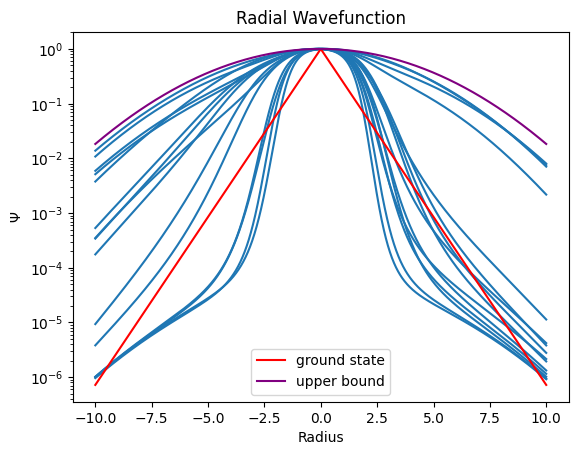

In [78]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

getLine = jax.vmap(getLine, in_axes=[0,0])

phi = jax.random.uniform(key, shape = (15,)) * 2 * jnp.pi
theta = jax.random.uniform(key, shape = (15,)) * jnp.pi

r, line = getLine(phi,theta)

for i in range(15):
    prob = wavefun.calc_logpsi(parameters, line[i])
    plt.plot(r[i], jnp.exp(prob)/jnp.max(jnp.exp(prob)), color = "C0")


s = np.linspace(-10,10, num = 500)
plt.plot(s, jnp.exp(-jnp.abs(s)*jnp.sqrt(2)), color = "red", label = "ground state")
plt.plot(s, jnp.exp(-s**2/5**2), color = "purple", label = "upper bound")

plt.yscale("log")

plt.legend()

plt.xlabel("Radius")
plt.ylabel("$\\Psi$")

plt.title("Radial Wavefunction")


## Initialise a MC-Sampler

In [79]:
sampler = module.samplers.MCMC(wavefun, variance = 0.1)

In [80]:
N = 10000
samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), N)
H_loc = H.calc_H_loc(wavefun, parameters, samples)

print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc)/jnp.sqrt(N))

Acceptance Ratio: 0.86869997
Expected Energy: -0.36176738
Std of Expected Energy: 0.005198534


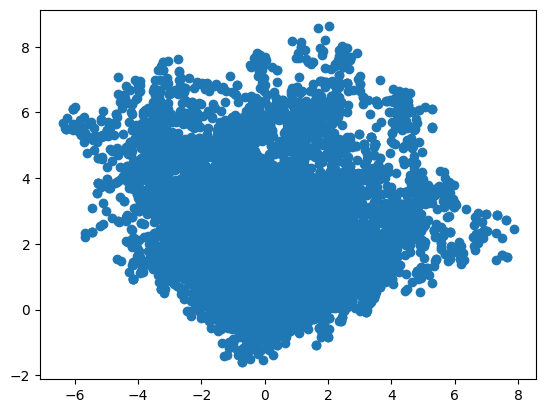

In [81]:
plt.scatter(samples[:, 0], samples[:, 1])

To estimate the gradient of the expected energy via the formula:

$$
\nabla \left< E \right>  = 2\,\Re\, \mathbb{E}\{\nabla \log \Psi [H_{\mathrm{loc}}(r) - \mathbb{E}(E)]\}
$$

we implement a help function:

In [82]:
@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc)
    dE = jnp.std(E_loc)
    grad_log = orbital.grad_logpsi(parameters, samples)

    return jax.tree_util.tree_map(lambda tree: 2*jnp.real(jnp.mean(jnp.swapaxes(jnp.swapaxes(tree, 0, -1) * (E_loc - E), 0, -1), axis = 0)), grad_log), E, dE

The energy can now be optimised:

In [83]:
Es_ = []
dEs_ = []
ratios_ = []

In [84]:
# define
optimizer = optax.adam(learning_rate=0.01)

# initialise
optimizer_state = optimizer.init(parameters)

for i in tqdm(range(400)):
    key, _ = jax.random.split(key)
    samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), 20000)
    grad, E, dE = calc_grad_E(H, wavefun, parameters, samples)

    Es_.append(E)
    dEs_.append(dE)
    ratios_.append(ratio)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, parameters)

    parameters = optax.apply_updates(parameters, updates)

Es = np.array(Es_)
dEs = np.array(dEs_) / np.sqrt(10000)
ratios = np.array(ratios_)

100%|██████████| 400/400 [00:17<00:00, 22.97it/s]


Text(0.5, 1.0, 'Energy Optimisation')

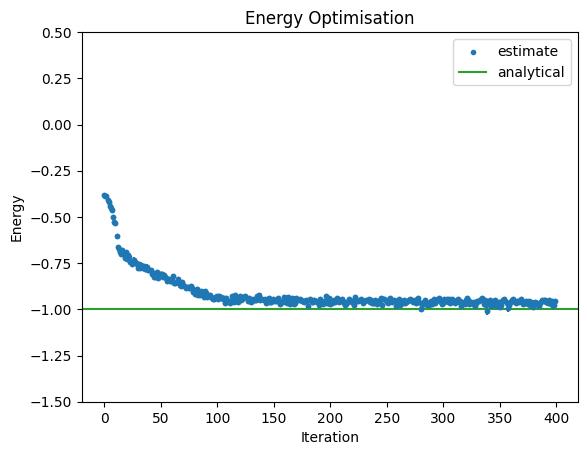

In [85]:
index = np.arange(Es.shape[0])

plt.scatter(index, Es, label = "estimate", marker = ".")
# plt.fill_between(index, Es - dEs, Es + dEs, alpha = 0.7, label = "$\\pm \\sigma$", color = "C3")
plt.errorbar(index, Es, yerr = dEs, fmt = ".")
plt.ylim(-1.5,0.5)
# plt.xlim(200,300)
plt.axhline(-1, color = "C2", label = "analytical")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Energy Optimisation")

Text(0.5, 1.0, 'Energy Optimisation')

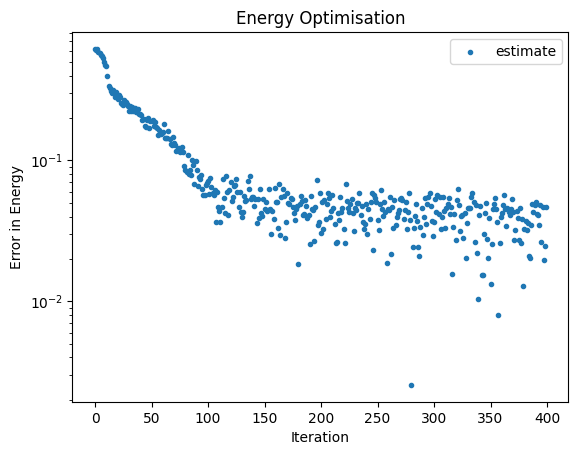

In [86]:
index = np.arange(Es.shape[0])

# plt.errorbar(index, np.abs(Es + 1), yerr = dEs, label = "estimate", fmt = ".")
plt.scatter(index, np.abs(Es + 1), label = "estimate", marker = ".")
# plt.fill_between(index, Es - dEs, Es + dEs, alpha = 0.4, label = "$\\pm \\sigma$")
# plt.ylim(-2,2)
# plt.axhline(-1, color = "C2", label = "analytical")
plt.yscale("log")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Error in Energy")
plt.title("Energy Optimisation")

Now, the variance of the expected energy has decreased, as expected for correct eigenstate:

In [87]:
N = 10000
samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), N)
H_loc = H.calc_H_loc(wavefun, parameters, samples)

print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc)/jnp.sqrt(N))

Acceptance Ratio: 0.6799
Expected Energy: -0.97128004
Std of Expected Energy: 0.008226362


Text(0.5, 1.0, 'Radial Wavefunction')

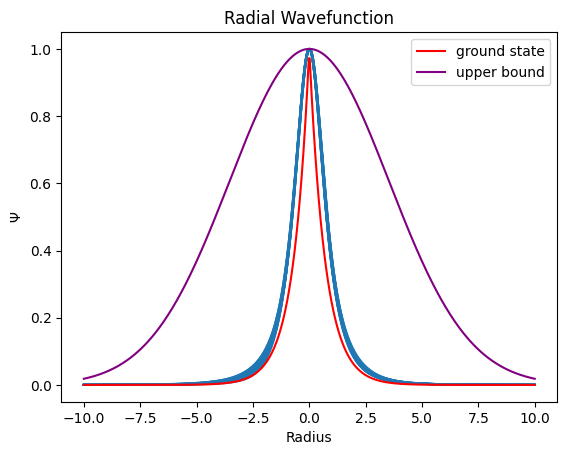

In [88]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

getLine = jax.vmap(getLine, in_axes=[0,0])

phi = jax.random.uniform(key, shape = (15,)) * 2 * jnp.pi
theta = jax.random.uniform(key, shape = (15,)) * jnp.pi

r, line = getLine(phi,theta)

for i in range(15):
    prob = wavefun.calc_logpsi(parameters, line[i])
    plt.plot(r[i], jnp.exp(prob)/jnp.max(jnp.exp(prob)), color = "C0")


s = np.linspace(-10,10, num = 500)
plt.plot(s, jnp.exp(-jnp.abs(s)*jnp.sqrt(2)), color = "red", label = "ground state")
plt.plot(s, jnp.exp(-s**2/5**2), color = "purple", label = "upper bound")

# plt.yscale("log")

plt.legend()

plt.xlabel("Radius")
plt.ylabel("$\\Psi$")

plt.title("Radial Wavefunction")


---